<h4 style="font-size: 30px;"><strong>Packages</strong></h4>


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FixedLocator
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from glob import glob
import calendar


<h4 style="font-size: 30px;"><strong>Paths</strong></h4>

In [4]:
hourly_input = '../../DATA/rainfall/hourly_gauges_SIATA_EPM/'
daily_output = '../../DATA/rainfall/daily_gauges_SIATA_EPM/'
monthly_output = '../../DATA/rainfall/monthly_gauges_SIATA_EPM/'
annual_output = '../../DATA/rainfall/annual_gauges_SIATA_EPM/'
path_ENSO = '../../DATA/rainfall/ENSO/'
path_inventory = '../../DATA/landslides/'
output_figures = '../../FIGURES/temporal_analysis/'


<h4 style="font-size: 30px;"><strong>Daily, monthly and annual series for each rain gauge</strong></h4>


In [2]:
hourly_input = '../../DATA/rainfall/hourly_gauges_SIATA_EPM/'
daily_output = '../../DATA/rainfall/daily_gauges_SIATA_EPM/'
monthly_output = '../../DATA/rainfall/monthly_gauges_SIATA_EPM/'
annual_output = '../../DATA/rainfall/annual_gauges_SIATA_EPM/'

ENSO = '../../DATA/rainfall/ENSO/'

csv_files = [f for f in os.listdir(hourly_input) if f.endswith('.csv')]

def custom_agg(x, threshold):
    return np.nan if np.isnan(x).sum() >= threshold else x.sum(min_count=1)

In [18]:
for file in csv_files:
    print(f"Processing {file}")
    df = pd.read_csv(os.path.join(hourly_input, file))
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    df.dropna(subset=['P'], inplace=True)

    daily_threshold = int(24)  # 24 hours in a day
    monthly_threshold = int(24 * 30.44)  # Aprox. 30.44 días en un mes (promedio)
    annual_threshold = int(24 * 365.25)  # 365.25 días en un año (promedio)

    daily_data = df.resample('D', on='Fecha').agg(lambda x: custom_agg(x, daily_threshold))
    monthly_data = df.resample('M', on='Fecha').agg(lambda x: custom_agg(x, monthly_threshold))
    annual_data = df.resample('Y', on='Fecha').agg(lambda x: custom_agg(x, annual_threshold))
    
    station_number = file.split('_')[-1].replace('.csv', '')
    
    #Save daily series
    daily_output_file = f"{daily_output}Daily_Est_{station_number}.csv"
    daily_data['P'].to_csv(daily_output_file, header=['P'], index_label='Fecha')
    
    #Save monthly series
    monthly_output_file = f"{monthly_output}Monthly_Est_{station_number}.csv"
    monthly_data['P'].to_csv(monthly_output_file, header=['P'], index_label='Fecha')
    
    #Save annual series
    annual_output_file = f"{annual_output}Annual_Est_{station_number}.csv"
    annual_data['P'].to_csv(annual_output_file, header=['P'], index_label='Fecha')

print("Monthly and annual series saved")

Processing H_Datos_Procesados_Est_18.csv
Processing H_Datos_Procesados_Est_607.csv
Processing H_Datos_Procesados_Est_62.csv
Processing H_Datos_Procesados_Est_242.csv
Processing H_Datos_Procesados_Est_394.csv
Processing H_Datos_Procesados_Est_447.csv
Processing H_Datos_Procesados_Est_11.csv
Processing H_Datos_Procesados_Est_35.csv
Processing H_Datos_Procesados_Est_47.csv
Processing H_Datos_Procesados_Est_601.csv
Processing H_Datos_Procesados_Est_61.csv
Processing H_Datos_Procesados_Est_40.csv
Processing H_Datos_Procesados_Est_551.csv
Processing H_Datos_Procesados_Est_58.csv
Processing H_Datos_Procesados_Est_154.csv
Processing H_Datos_Procesados_Est_437.csv
Processing H_Datos_Procesados_Est_46.csv
Processing H_Datos_Procesados_Est_230.csv
Processing H_Datos_Procesados_Est_48.csv
Processing H_Datos_Procesados_Est_3.csv
Processing H_Datos_Procesados_Est_41.csv
Processing H_Datos_Procesados_Est_30.csv
Processing H_Datos_Procesados_Est_274.csv
Processing H_Datos_Procesados_Est_2701481.csv
Pr

<h4 style="font-size: 30px;"><strong>Annual temporal scale considering the ENSO</strong></h4>

<h4 style="font-size: 20px;"><strong>ENSO</strong></h4>


In [4]:
enso_df = pd.read_excel(f'{path_ENSO}ONI.xlsx', index_col=0)

# Convertir ENSO a una serie de tiempo mensual
enso_df.columns = np.arange(1, 13)
enso_series = enso_df.stack().reset_index()
enso_series.columns = ['Year', 'Month', 'ENSO']
enso_series['Date'] = pd.to_datetime(enso_series[['Year', 'Month']].assign(day=1))

# Filtrar los datos para incluir solo el rango entre 1950-01-01 y 2024-01-01
start_date = "1950-01-01"
end_date = "2024-01-01"
enso_series = enso_series[(enso_series['Date'] >= start_date) & (enso_series['Date'] < end_date)]

# Diccionario para mapear los números de los meses a nombres abreviados
month_mapping = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

# Convertir los números de los meses a los nombres abreviados
enso_series['Month'] = enso_series['Month'].map(month_mapping)

# Clasificar ENSO en categorías
enso_series['ENSO_Category'] = pd.cut(
    enso_series['ENSO'], 
    bins=[-np.inf, -2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2, np.inf], 
    labels=['La Niña-Super', 'La Niña-Strong', 'La Niña-Moderate', 'La Niña-Weak', 'Neutro', 
            'El Niño-Weak', 'El Niño-Strong', 'El Niño-Moderate', 'El Niño-Super']
)

# Mapa de colores para las categorías ENSO
cmap_dict = {
    'La Niña-super': '#001F3F', 'La Niña-Strong': '#0074D9', 'La Niña-Moderate': '#3BADC9', 'La Niña-Weak': '#7FDBFF',
    'Neutro': '#E0E0E0', 'El Niño-Weak': '#FF9999', 'El Niño-Strong': '#FF6666', 'El Niño-Moderate': '#FF4D4D', 
    'El Niño-super': '#800020'
}
cmap_class = ListedColormap([cmap_dict[i] for i in cmap_dict])

In [5]:
# Convertir los nombres de los meses a un tipo categórico con un orden específico
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dec']
enso_series['Month'] = pd.Categorical(enso_series['Month'], categories=month_order, ordered=True)

<h4 style="font-size: 20px;"><strong>Landslides</strong></h4>


In [6]:
month_mapping = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

landslides_df = pd.read_csv(f'{path_inventory}inventory_GEOHAZARDS_20240824.csv')
landslides_df['Fecha'] = pd.to_datetime(landslides_df['Fecha'], errors='coerce')

# Filtrar los deslizamientos para incluir solo los datos desde 1950
landslides_df = landslides_df[(landslides_df['Fecha'] >= '1950-01-01') & (landslides_df['Fecha'] <= '2024-01-01')]

# Crear una serie temporal de deslizamientos por mes
landslides_series = landslides_df.resample('M', on='Fecha').size()

# Extraer el año y el mes de landslides_series
landslides_series = landslides_series.reset_index()
landslides_series['Year'] = landslides_series['Fecha'].dt.year
landslides_series['Month'] = landslides_series['Fecha'].dt.month.map(month_mapping)

# Convertir los nombres de los meses a un tipo categórico con un orden específico
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dec']
landslides_series['Month'] = pd.Categorical(landslides_series['Month'], categories=month_order, ordered=True)

# Agrupar por año y mes para contar los deslizamientos en cada combinación
landslides_pivot = landslides_series.pivot_table(index='Month', columns='Year', values=0, aggfunc='sum').fillna(0).astype(int)

<h4 style="font-size: 20px;"><strong>Rainfall</strong></h4>


In [7]:
monthly_files = sorted(glob(monthly_output + 'Monthly_Est_*.csv'))
stations_with_paths = [(int(file.split('_')[-1].split('.')[0]), file) for file in monthly_files]

# Ordenar las rutas de los archivos por el número de la estación
stations_with_paths_sorted = sorted(stations_with_paths, key=lambda x: x[0])

# Extraer solo las rutas ordenadas
monthly_files = [station[1] for station in stations_with_paths_sorted]

# Crear un dataframe para almacenar el promedio mensual de precipitación de todas las estaciones
all_stations_df = pd.DataFrame()

for file in monthly_files:
    station_data = pd.read_csv(file, index_col='Fecha', parse_dates=True)
    all_stations_df = pd.concat([all_stations_df, station_data], axis=1)

# Filtrar los datos para incluir solo registros desde 1950
all_stations_df = all_stations_df[(all_stations_df.index >= '1950-01-01') & (all_stations_df.index <= '2023-12-31')]

# Calcular el promedio mensual de todas las estaciones
rainfall_series = all_stations_df.mean(axis=1).resample('M').sum()

In [8]:
# Diccionario para mapear los números de los meses a nombres abreviados
month_mapping = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
# Agrupar la serie de precipitación por mes (en números) y sumarla
monthly_rainfall_sum = rainfall_series.groupby(rainfall_series.index.month).mean()

# Mapear los números de los meses a los nombres de los meses
monthly_rainfall_sum.index = monthly_rainfall_sum.index.map(month_mapping)
monthly_rainfall_sum = monthly_rainfall_sum.reindex(month_order)


<h4 style="font-size: 20px;"><strong>Matrix</strong></h4>

In [9]:
# Organizar los datos para el gráfico
enso_matrix = enso_series.pivot_table(index='Month', columns='Year', values='ENSO_Category', aggfunc='first').reindex(index=month_order)
df_class = pd.DataFrame({
    'year': np.repeat(enso_matrix.columns, enso_matrix.index.size),
    'month': np.tile(enso_matrix.index, enso_matrix.columns.size),
    'E': enso_matrix.values.ravel(),
    'anot': np.zeros(enso_matrix.values.ravel().shape)  # Placeholder para anotaciones (como deslizamientos)
})

# Crear las matrices de datos para el gráfico
y = enso_matrix.columns.size
m = enso_matrix.index.size
data_P = enso_matrix.applymap(lambda x: list(cmap_dict.keys()).index(x) if pd.notna(x) else np.nan).values

# Crear una matriz de anotaciones (número de deslizamientos por mes y año)
landslides_pivot = landslides_series.pivot_table(index='Month', columns='Year', values=0, aggfunc='sum').reindex(index=month_order)
landslides_matrix = landslides_pivot.reindex(index=enso_matrix.index, columns=enso_matrix.columns).fillna(0).astype(int)
annot_labels = landslides_matrix.applymap(str).replace('0', '')  # Reemplazar los ceros con cadenas vacías
data_M = annot_labels.values  # Convertir a matriz

In [10]:
enso_matrix

Year,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Month,,,,,,,,,,,,,,,,,,,,,
Jan,La Niña-Strong,La Niña-Weak,Neutro,Neutro,El Niño-Weak,La Niña-Weak,La Niña-Moderate,Neutro,El Niño-Moderate,El Niño-Weak,...,Neutro,Neutro,El Niño-super,Neutro,La Niña-Weak,El Niño-Weak,Neutro,La Niña-Moderate,La Niña-Moderate,La Niña-Weak
Feb,La Niña-Moderate,La Niña-Weak,Neutro,El Niño-Weak,Neutro,La Niña-Weak,La Niña-Weak,Neutro,El Niño-Moderate,El Niño-Weak,...,La Niña-Weak,Neutro,El Niño-super,Neutro,La Niña-Weak,El Niño-Weak,Neutro,La Niña-Weak,La Niña-Weak,Neutro
Mar,La Niña-Moderate,Neutro,Neutro,El Niño-Weak,Neutro,La Niña-Weak,La Niña-Weak,Neutro,El Niño-Strong,Neutro,...,Neutro,Neutro,El Niño-Moderate,Neutro,La Niña-Weak,El Niño-Weak,Neutro,La Niña-Weak,La Niña-Moderate,Neutro
Apr,La Niña-Moderate,Neutro,Neutro,El Niño-Weak,Neutro,La Niña-Weak,La Niña-Weak,El Niño-Weak,El Niño-Weak,Neutro,...,Neutro,El Niño-Weak,El Niño-Weak,Neutro,La Niña-Weak,El Niño-Weak,Neutro,La Niña-Weak,La Niña-Moderate,Neutro
May,La Niña-Moderate,Neutro,Neutro,El Niño-Weak,La Niña-Weak,La Niña-Weak,La Niña-Weak,El Niño-Weak,El Niño-Weak,Neutro,...,Neutro,El Niño-Weak,Neutro,Neutro,Neutro,Neutro,Neutro,La Niña-Weak,La Niña-Moderate,Neutro
Jun,La Niña-Weak,El Niño-Weak,Neutro,El Niño-Weak,La Niña-Weak,La Niña-Weak,La Niña-Weak,El Niño-Strong,El Niño-Weak,Neutro,...,Neutro,El Niño-Strong,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,La Niña-Weak,El Niño-Weak
Jul,La Niña-Weak,El Niño-Weak,Neutro,El Niño-Weak,La Niña-Weak,La Niña-Weak,La Niña-Weak,El Niño-Strong,El Niño-Weak,Neutro,...,Neutro,El Niño-Strong,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,La Niña-Weak,El Niño-Strong
Ago,Neutro,El Niño-Weak,Neutro,El Niño-Weak,La Niña-Weak,La Niña-Weak,La Niña-Weak,El Niño-Strong,Neutro,Neutro,...,Neutro,El Niño-Moderate,La Niña-Weak,Neutro,Neutro,Neutro,La Niña-Weak,La Niña-Weak,La Niña-Weak,El Niño-Strong
Sep,Neutro,El Niño-Weak,Neutro,El Niño-Weak,La Niña-Weak,La Niña-Moderate,La Niña-Weak,El Niño-Strong,Neutro,Neutro,...,Neutro,El Niño-super,La Niña-Weak,Neutro,Neutro,Neutro,La Niña-Weak,La Niña-Weak,La Niña-Moderate,El Niño-Moderate


<h4 style="font-size: 20px;"><strong>Graphic</strong></h4>

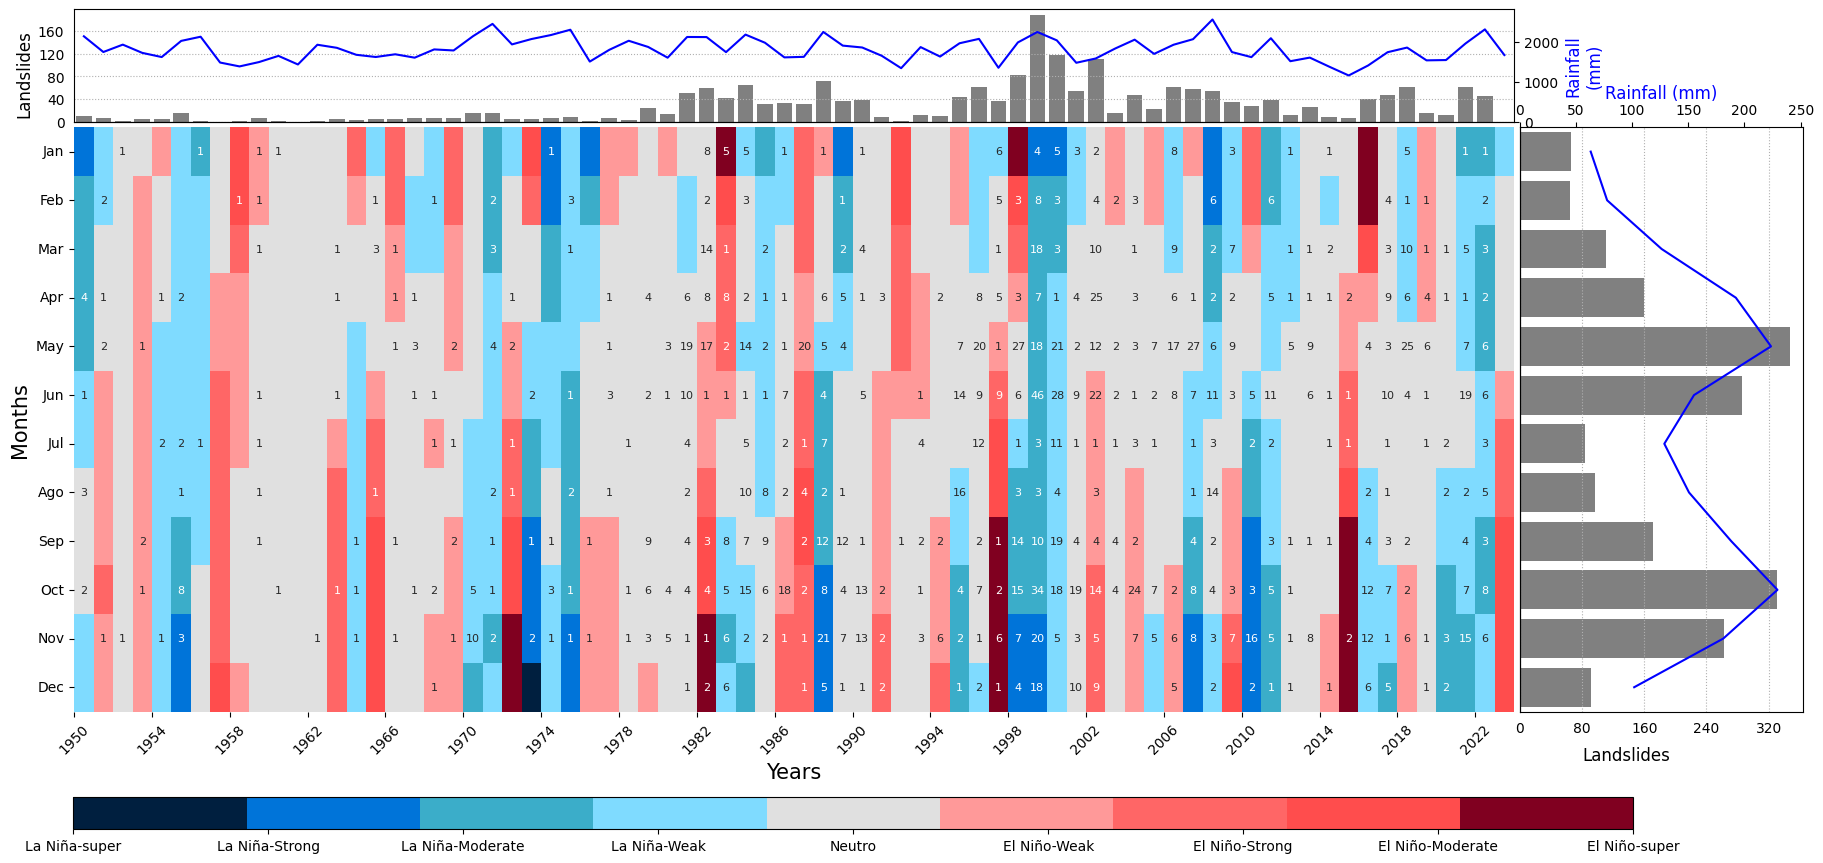

In [12]:
# Gráfico principal con barras marginales y mapa de calor ENSO
g = sns.jointplot(data=df_class, x='year', y='month', kind='hist', bins=(y, m), cmap='hot')
g.ax_marg_y.cla()  # Limpia el eje marginal Y
g.ax_marg_x.cla()  # Limpia el eje marginal X

# Heatmap ENSO con anotaciones de deslizamientos
sns.heatmap(data=data_P, annot=data_M, ax=g.ax_joint, cbar=False, cmap=cmap_class, annot_kws={"size":8}, fmt='')

# Dibujar barras de deslizamientos y precipitación
df_y = landslides_matrix.sum(axis=0)  # Suma de deslizamientos por año
df_m = landslides_matrix.sum(axis=1)  # Suma de deslizamientos por mes

# Dibujar las barras de deslizamientos
g.ax_marg_y.barh(np.arange(0.5, m), df_m, color='gray')
g.ax_marg_x.bar(np.arange(0.5, y), df_y, color='gray')

# Etiquetas para los ejes de deslizamientos
g.ax_marg_x.set_ylabel('Landslides', fontsize=12)  # Etiqueta en el eje izquierdo de la gráfica superior
g.ax_marg_y.set_xlabel('Landslides', fontsize=12)  # Etiqueta en el eje derecho de la gráfica lateral derecha

# Precipitación acumulada en los ejes secundarios
ax2 = g.ax_marg_x.twinx()
P_y = rainfall_series.groupby(rainfall_series.index.year).sum().reindex(enso_matrix.columns, fill_value=0)
ax2.plot(np.arange(0.5, y), P_y, color='blue')
ax2.set_ylabel('Rainfall\n(mm)', fontsize=12, color='blue')
ax2.set_ylim(0, P_y.max() * 1.1)

ax2y = g.ax_marg_y.twiny()
P_m = monthly_rainfall_sum.reindex(enso_matrix.index, fill_value=0)
ax2y.plot(P_m, np.arange(0.5, m), color='blue')
ax2y.set_xlabel('Rainfall (mm)', fontsize=12, color='blue')
ax2y.set_xlim(0, P_m.max() * 1.1)

# Configuración de ejes y etiquetas
g.ax_joint.set_xticks(np.arange(0, y, 4))
g.ax_joint.set_xticklabels(np.arange(enso_matrix.columns[0], enso_matrix.columns[-1], 4), rotation=45)
g.ax_joint.set_yticks(np.arange(0.5, m))
g.ax_joint.set_yticklabels(enso_matrix.index, rotation=0)

g.ax_joint.set_xlabel('Years', fontsize=15)
g.ax_joint.set_ylabel('Months', fontsize=15)

# Ajustes de diseño
g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

g.fig.set_size_inches(20, 8)
g.fig.subplots_adjust(hspace=0.05, wspace=0.02)

# Ajustar la barra de color para ENSO
cbar = g.fig.colorbar(g.ax_joint.collections[1], ax=[g.ax_joint, g.ax_marg_y, g.ax_marg_x], use_gridspec=True,
                      orientation='horizontal',
                      cax=g.fig.add_axes([0.11, -0.05, 0.78, 0.04]))

# Asigna el locator a la barra de color
n_classes = 9  # Número de categorías en la barra de color
cbar.ax.xaxis.set_major_locator(FixedLocator([i for i in range(n_classes)]))

# Configura las etiquetas de la barra de color
cbar.ax.set_xticklabels(['La Niña-super', 'La Niña-Strong', 'La Niña-Moderate', 'La Niña-Weak', 'Neutro',
                         'El Niño-Weak', 'El Niño-Strong', 'El Niño-Moderate', 'El Niño-super'], fontsize=10, rotation=0)

g.ax_marg_y.tick_params(labelbottom=True)
g.ax_marg_y.grid(True, axis='x', ls=':')
g.ax_marg_y.xaxis.set_major_locator(MaxNLocator(6))

g.ax_marg_x.tick_params(labelleft=True)
g.ax_marg_x.grid(True, axis='y', ls=':')
g.ax_marg_x.yaxis.set_major_locator(MaxNLocator(6))

# Añadir etiquetas de deslizamientos
font_dict = ax2y.xaxis.label.get_font_properties().copy()
g.ax_marg_y.text(80, 13, 'Landslides', fontproperties=font_dict)

font_dict = ax2.yaxis.label.get_font_properties().copy()
g.ax_marg_x.text(-3, 15, 'Landslides', fontproperties=font_dict, rotation=90)

plt.show()

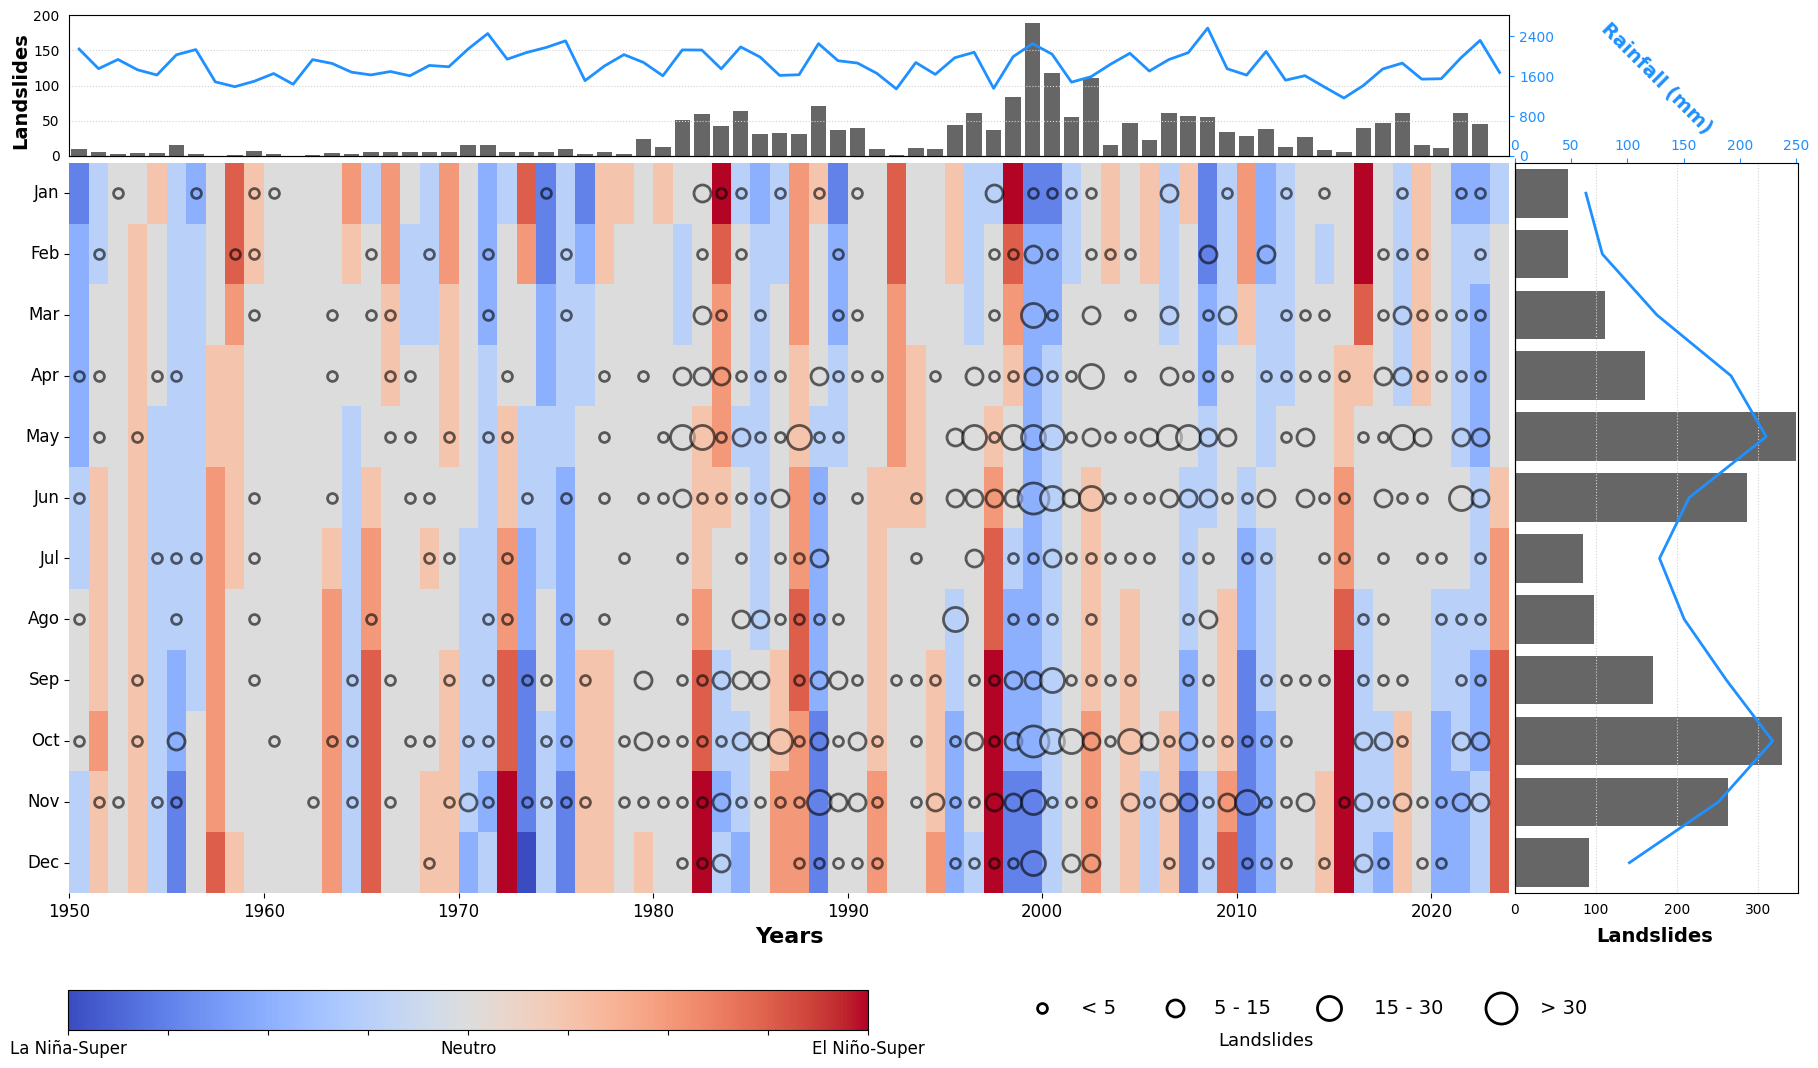

In [79]:
# Crear el jointplot
g = sns.jointplot(data=df_class, x='year', y='month', kind='hist', bins=(y, m), cmap='YlOrRd')
g.ax_marg_y.cla()  # Limpia el eje marginal Y
g.ax_marg_x.cla()  # Limpia el eje marginal X

# Heatmap ENSO con anotaciones de deslizamientos
sns.heatmap(data=data_P, ax=g.ax_joint, cbar=False, cmap='coolwarm')  # Usa el eje 'ax_joint' de jointplot

# Crear los círculos en lugar de anotaciones de texto
data_M = np.array(data_M, dtype=object)
data_M = np.where(data_M == '', '0', data_M)

data_M = data_M.astype(int)

# Obtener la paleta de colores del heatmap
norm = mcolors.Normalize(vmin=np.min(data_P), vmax=np.max(data_P))  # Normalizar en base a los valores de ENSO
cmap = plt.get_cmap('coolwarm')  # Colormap usado en el heatmap

# Definir los tamaños de los círculos según los intervalos
def get_circle_size(value):
    if value == 0:
        return 0  # Sin círculo
    elif 1 <= value <= 5:
        return 50  # Círculo pequeño
    elif 6 <= value <= 15:
        return 150  # Círculo mediano
    elif 16 <= value <= 30:
        return 300  # Círculo grande
    else:
        return 500  # Círculo muy grande

# Crear una matriz con los tamaños escalados
scaled_sizes = np.array([[get_circle_size(val) for val in row] for row in data_M])

# Dibujar los círculos sobre el heatmap con colores basados en los valores de ENSO
for (i, j), val in np.ndenumerate(data_M):
    if val > 0:  # Solo dibujar círculos donde hay deslizamientos
        color = cmap(norm(data_P[i, j]))  # Obtener el color basado en el valor ENSO
        g.ax_joint.scatter(j + 0.5, i + 0.5, s=scaled_sizes[i, j], color=color, alpha=0.6, edgecolor='black',lw=2)

# Crear leyenda personalizada para los tamaños de los círculos
legend_labels = ['< 5', '5 - 15', ' 15 - 30', '> 30']
legend_sizes = [50, 150, 300, 500]

# Posicionar la leyenda en la esquina inferior derecha usando bbox_to_anchor
legend_circles = [plt.scatter([], [], s=size, color='white', edgecolor='black', linewidth=2) for size in legend_sizes]
g.ax_joint.legend(legend_circles, legend_labels, loc='upper left', bbox_to_anchor=(0.65, -0.12), 
                  handletextpad=1, labelspacing=1.2, ncol=4, fontsize=14, frameon=False)

# Dibujar barras de deslizamientos y precipitación
df_y = landslides_matrix.sum(axis=0)  # Suma de deslizamientos por año
df_m = landslides_matrix.sum(axis=1)  # Suma de deslizamientos por mes

# Dibujar las barras de deslizamientos con transparencia
g.ax_marg_y.barh(np.arange(0.5, m), df_m, color='black', alpha=0.6)
g.ax_marg_x.bar(np.arange(0.5, y), df_y, color='black', alpha=0.6)

# Precipitación acumulada en los ejes secundarios con líneas más estilizadas
ax2 = g.ax_marg_x.twinx()
P_y = rainfall_series.groupby(rainfall_series.index.year).sum().reindex(enso_matrix.columns, fill_value=0)
ax2.tick_params(axis='y', colors='dodgerblue')
ax2.plot(np.arange(0.5, y), P_y, color='dodgerblue', linewidth=2, linestyle='-')

ax2.set_ylim(0, P_y.max() * 1.1)

# Añadir más divisiones en los ticks mayores usando MaxNLocator
ax2.yaxis.set_major_locator(MaxNLocator(nbins=4))  # Ajustar nbins a un valor mayor para más divisiones

ax2y = g.ax_marg_y.twiny()
P_m = monthly_rainfall_sum.reindex(enso_matrix.index, fill_value=0)
ax2y.plot(P_m, np.arange(0.5, m), color='dodgerblue', linewidth=2, linestyle='-')
ax2y.tick_params(axis='x', colors='dodgerblue')
ax2y.set_xlabel('Rainfall (mm)', fontsize=14, color='dodgerblue', fontweight='bold', rotation=-45)
ax2y.set_xlim(0, P_m.max() * 1.1)

# Configuración de ejes y etiquetas
g.ax_joint.set_xticks(np.arange(0, y, 10))
g.ax_joint.set_xticklabels(np.arange(enso_matrix.columns[0], enso_matrix.columns[-1], 10), rotation=0, fontsize=12)
g.ax_joint.set_yticks(np.arange(0.5, m))
g.ax_joint.set_yticklabels(enso_matrix.index, rotation=0, fontsize=12)

g.ax_joint.set_xlabel('Years', fontsize=16, fontweight='bold')

# Ajustes de diseño
g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

g.fig.set_size_inches(20, 10)
g.fig.subplots_adjust(hspace=0.05, wspace=0.02)

# Crear la barra de color más pequeña
# Ajustar la altura de la barra de color (por ejemplo, 0.02 de altura en lugar de 0.04)
cax = g.fig.add_axes([0.11, -0.04, 0.40, 0.04])  # Cambiar la última coordenada para hacerla más pequeña

# Crear la barra de color con las nuevas dimensiones
cbar = g.fig.colorbar(g.ax_joint.collections[1], cax=cax, orientation='horizontal')

# Asigna el locator a la barra de color
n_classes = 9
cbar.ax.xaxis.set_major_locator(FixedLocator([i for i in range(n_classes)]))

# Configura las etiquetas de la barra de color
cbar.ax.set_xticklabels(['La Niña-Super', ' ', ' ', ' ', 'Neutro',' ', ' ', ' ', 'El Niño-Super'], fontsize=12, rotation=0, color='black')

# Añadir líneas de cuadrícula más sutiles
g.ax_marg_y.grid(True, axis='x', ls=':', color='lightgray')
g.ax_marg_x.grid(True, axis='y', ls=':', color='lightgray')


g.ax_marg_y.tick_params(labelbottom=True)
g.ax_marg_y.grid(True, axis='x', ls=':')
g.ax_marg_y.set_xlim(0,350)

g.ax_marg_x.tick_params(labelleft=True)
g.ax_marg_x.grid(True, axis='y', ls=':')
g.ax_marg_x.set_ylim(0,200)

# Añadir etiquetas de deslizamientos
font_dict = ax2y.xaxis.label.get_font_properties().copy()
g.ax_marg_y.text(100, 12.8, 'Landslides', fontproperties=font_dict) # Right bar plot
g.ax_marg_x.text(-3, 15, 'Landslides', fontproperties=font_dict, rotation=90) # Upper bar plot

# Label para la leyenda de circulos
plt.text(11.5,-0.4, 'Landslides', fontsize = 13)
plt.show()
g.fig.savefig(f'{output_figures}annual_temporal_ENSO.png', bbox_inches = "tight")

<h4 style="font-size: 30px;"><strong>Monthly temporal scale considering the ENSO</strong></h4>

<h4 style="font-size: 20px;"><strong>ENSO</strong></h4>

In [15]:
enso_df = pd.read_excel(f'{path_ENSO}ONI.xlsx', index_col=0)
enso_df=enso_df.loc[1972:2017]
enso_df.columns=np.arange(1,13)
ENSO_values=(np.array(enso_df).ravel())
ENSO_dates=pd.date_range('1972-01-01','2017-12-31', freq='M')
ENSO_df=pd.DataFrame({'ENSO':ENSO_values}, index=ENSO_dates)
ENSO_df['ID_ENSO']=np.where(ENSO_df>=0.5,1,np.where(ENSO_df<=-0.5,-1,0))

<h4 style="font-size: 20px;"><strong>Rainfall</strong></h4>

In [41]:
monthly_files = sorted(glob(monthly_output + 'Monthly_Est_*.csv'))
stations_with_paths = [(int(file.split('_')[-1].split('.')[0]), file) for file in monthly_files]

stations_with_paths_sorted = sorted(stations_with_paths, key=lambda x: x[0])
monthly_files = [station[1] for station in stations_with_paths_sorted]

all_stations_df = pd.DataFrame()

#Solo con las estaciones de EPM
for file in monthly_files[-16:]:
    station_data = pd.read_csv(file, index_col='Fecha', parse_dates=True)
    all_stations_df = pd.concat([all_stations_df, station_data], axis=1)

all_stations_df = all_stations_df[(all_stations_df.index >= '1972-01-01') & (all_stations_df.index <= '2017-12-31')]

monthly_rainfall_df = all_stations_df.groupby([ENSO_df['ID_ENSO'], all_stations_df.index.month]).mean()

<h4 style="font-size: 20px;"><strong>Landslides</strong></h4>

In [43]:
landslides_df = pd.read_csv(f'{path_inventory}inventory_GEOHAZARDS_20240824.csv')
landslides_df['Fecha'] = pd.to_datetime(landslides_df['Fecha'], errors='coerce')

landslides_df = landslides_df[(landslides_df['Fecha'] >= '1972-01-01') & (landslides_df['Fecha'] <= '2017-12-31')]
landslides_series = landslides_df.resample('M', on='Fecha').size()
landslides_series = landslides_series.reset_index(name='Count')  

landslides_series['Year'] = landslides_series['Fecha'].dt.year
landslides_series['Month'] = landslides_series['Fecha'].dt.month

landslides_series = landslides_series.set_index('Fecha').join(ENSO_df['ID_ENSO'], how='left')

monthly_landslides_df = landslides_series.groupby(['ID_ENSO', landslides_series.index.month])['Count'].sum().unstack().fillna(0)

<h4 style="font-size: 20px;"><strong>ENSO: Rainfall + Landslides</strong></h4>

In [46]:
# Separar los datos por fases ENSO
rainfall_nina = monthly_rainfall_df.loc[-1]
rainfall_nino = monthly_rainfall_df.loc[1]
rainfall_neutro = monthly_rainfall_df.loc[0]

landslides_nina = monthly_landslides_df.loc[-1]
landslides_nino = monthly_landslides_df.loc[1]
landslides_neutro = monthly_landslides_df.loc[0]

<h4 style="font-size: 20px;"><strong>Graphics</strong></h4>

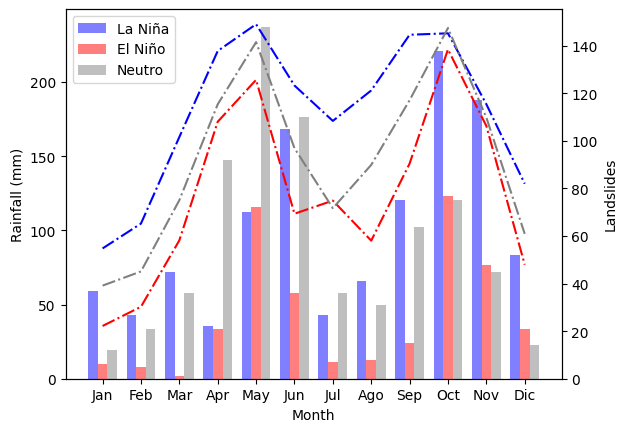

In [47]:
x = np.arange(1, 13)
Months_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Graficar las precipitaciones
ax1.plot(x, rainfall_nina.mean(axis=1), linestyle='-.', color='blue', label='La Niña')
ax1.plot(x, rainfall_nino.mean(axis=1), linestyle='-.', color='red', label='El Niño')
ax1.plot(x, rainfall_neutro.mean(axis=1), linestyle='-.', color='gray', label='Neutro')

# Graficar los deslizamientos como barras
w = 0.25
ax2.bar(x + w * -1, landslides_nina.values, width=w, color='blue', alpha=0.5, label='La Niña')
ax2.bar(x + w * 0, landslides_nino.values, width=w, color='red', alpha=0.5, label='El Niño')
ax2.bar(x + w * 1, landslides_neutro.values, width=w, color='gray', alpha=0.5, label='Neutro')

# Configuraciones del gráfico
ax1.set_xticks(x)
ax1.set_xticklabels(Months_names)
ax1.set_ylim(0)
ax1.set_xlabel('Month')
ax1.set_ylabel('Rainfall (mm)', color='k')
ax2.set_ylabel('Landslides', color='k')

ax1.set_zorder(1)  # para mantener ax1 al frente
ax1.patch.set_visible(False)  # para evitar que ax1 oculte ax2

ax2.legend(loc=2)

# Mostrar el gráfico
plt.show()

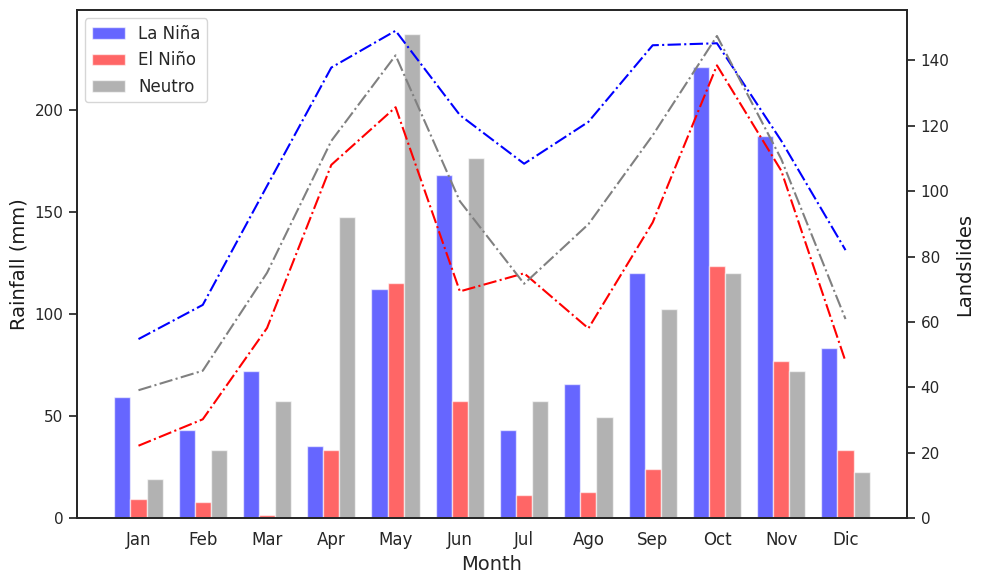

In [59]:
#Estilo de seaborn sin grillas
sns.set(style="white")

# Crear el gráfico
x = np.arange(1, 13)
Months_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Colores específicos (azul, rojo y gris)
colors = ['blue', 'red', 'gray']

# Graficar las precipitaciones con seaborn
sns.lineplot(x=x, y=rainfall_nina.mean(axis=1), ax=ax1, color=colors[0], linestyle='-.')
sns.lineplot(x=x, y=rainfall_nino.mean(axis=1), ax=ax1, color=colors[1], linestyle='-.')
sns.lineplot(x=x, y=rainfall_neutro.mean(axis=1), ax=ax1, color=colors[2], linestyle='-.')

# Graficar los deslizamientos como barras
w = 0.25
ax2.bar(x + w * -1, landslides_nina.values, width=w, color=colors[0], alpha=0.6, label='La Niña')
ax2.bar(x + w * 0, landslides_nino.values, width=w, color=colors[1], alpha=0.6, label='El Niño')
ax2.bar(x + w * 1, landslides_neutro.values, width=w, color=colors[2], alpha=0.6, label='Neutro')

# Configuraciones del gráfico
ax1.set_xticks(x)
ax1.set_xticklabels(Months_names, fontsize=12)
ax1.set_ylim(0)
ax1.set_xlabel('Month', fontsize=14)
ax1.set_ylabel('Rainfall (mm)', color='k', fontsize=14)
ax2.set_ylabel('Landslides', color='k', fontsize=14)

# Quitar gridlines
ax1.grid(False)

# Mantener ax1 al frente
ax1.set_zorder(1)
ax1.patch.set_visible(False)

# Leyenda combinada
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax2.legend(lines, labels, loc='upper left', fontsize=12)

# Mostrar el gráfico sin título
plt.tight_layout()
plt.show()
#guardar grafico
fig.savefig(f'{output_figures}monthly_temporal_ENSO.png', bbox_inches = "tight")

<h4 style="font-size: 30px;"><strong>Hourly and monthly scale</strong></h4>

<h4 style="font-size: 20px;"><strong>Landslides: DAGRD 2010-2023</strong></h4>

In [5]:
landslides_df = pd.read_csv(f'{path_inventory}inventory_DAGRD.csv')
landslides_df['fecha_hora_evento'] = pd.to_datetime(landslides_df['fecha_hora_evento'], errors='coerce')
landslides_df['Hora'] = landslides_df['fecha_hora_evento'].dt.hour
landslides_by_hour = landslides_df.groupby('Hora').size()

In [6]:
horas_reordenadas = list(range(7, 24)) + list(range(0, 7))
landslides_by_hour_month = landslides_df.groupby([landslides_df['fecha_hora_evento'].dt.month, landslides_df['Hora']]).size()
landslides_by_hour_month = landslides_by_hour_month.unstack().reindex(index=range(1, 13), columns=horas_reordenadas, fill_value=0)

In [7]:
landslides_by_hour_month

Hora,7,8,9,10,11,12,13,14,15,16,...,21,22,23,0,1,2,3,4,5,6
fecha_hora_evento,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,2.0,NaN,3.0,1.0,NaN,NaN,3.0,...,3.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN,1.0,2.0
2,NaN,2.0,1.0,NaN,1.0,1.0,NaN,1.0,4.0,1.0,...,NaN,1.0,1.0,4.0,NaN,NaN,NaN,NaN,1.0,2.0
3,1.0,5.0,3.0,4.0,NaN,7.0,2.0,5.0,7.0,4.0,...,2.0,4.0,6.0,9.0,2.0,5.0,5.0,2.0,1.0,3.0
4,1.0,NaN,3.0,1.0,6.0,4.0,2.0,3.0,10.0,11.0,...,3.0,1.0,4.0,10.0,3.0,1.0,26.0,1.0,5.0,4.0
5,8.0,4.0,6.0,7.0,5.0,4.0,1.0,8.0,15.0,12.0,...,4.0,17.0,8.0,15.0,3.0,5.0,3.0,2.0,8.0,14.0
6,9.0,11.0,2.0,8.0,8.0,18.0,6.0,11.0,5.0,10.0,...,11.0,8.0,19.0,21.0,7.0,16.0,14.0,10.0,13.0,10.0
7,NaN,4.0,3.0,5.0,1.0,10.0,2.0,5.0,3.0,1.0,...,1.0,1.0,5.0,12.0,4.0,2.0,NaN,2.0,4.0,5.0
8,5.0,3.0,3.0,4.0,3.0,4.0,1.0,NaN,3.0,7.0,...,5.0,6.0,7.0,18.0,2.0,5.0,5.0,1.0,3.0,1.0
9,2.0,2.0,2.0,2.0,4.0,4.0,NaN,4.0,NaN,4.0,...,4.0,2.0,1.0,12.0,2.0,3.0,2.0,2.0,1.0,2.0


<h4 style="font-size: 20px;"><strong>Rainfall: SIATA 2010-2023</strong></h4>

In [8]:
hourly_files = sorted(glob(hourly_input + 'H_Datos_Procesados_Est_*.csv'))

stations_with_paths = [(int(file.split('_')[-1].split('.')[0]), file) for file in hourly_files]

stations_with_paths_sorted = sorted(stations_with_paths, key=lambda x: x[0])
hourly_files = [station[1] for station in stations_with_paths_sorted]

all_stations_df = pd.DataFrame()

# Leer todos los archivos y almacenarlos en una lista
data_frames = []
for file in hourly_files[:-16]:  # Sólo con las estaciones de EPM
    station_data = pd.read_csv(file, index_col='Fecha', parse_dates=True)
    data_frames.append(station_data)

# Concatenar todos los DataFrames a la vez
all_stations_df = pd.concat(data_frames, axis=1)

all_stations_df = all_stations_df[(all_stations_df.index >= '2010-01-01') & (all_stations_df.index <= '2023-12-31')]

In [9]:
all_stations_df = all_stations_df.copy()
all_stations_df['Hora'] = all_stations_df.index.hour
# Agrupar por la columna 'Hora' y calcular el promedio para cada hora
mean_hourly_rainfall = all_stations_df.groupby('Hora').mean()
data_PM = mean_hourly_rainfall['P'].mean(axis=1) 

<h4 style="font-size: 20px;"><strong>Graphics hourly scale</strong></h4>

In [10]:
data_PM = pd.Series(data_PM)
landslides_by_hour = pd.Series(landslides_by_hour)
# Reordenar los datos según las nuevas horas
data_PM_reordenado = data_PM.reindex(horas_reordenadas)
landslides_by_hour_reordenado = landslides_by_hour.reindex(horas_reordenadas)
# Crear un índice para el eje X que represente las posiciones de las etiquetas
x_pos = range(len(horas_reordenadas))

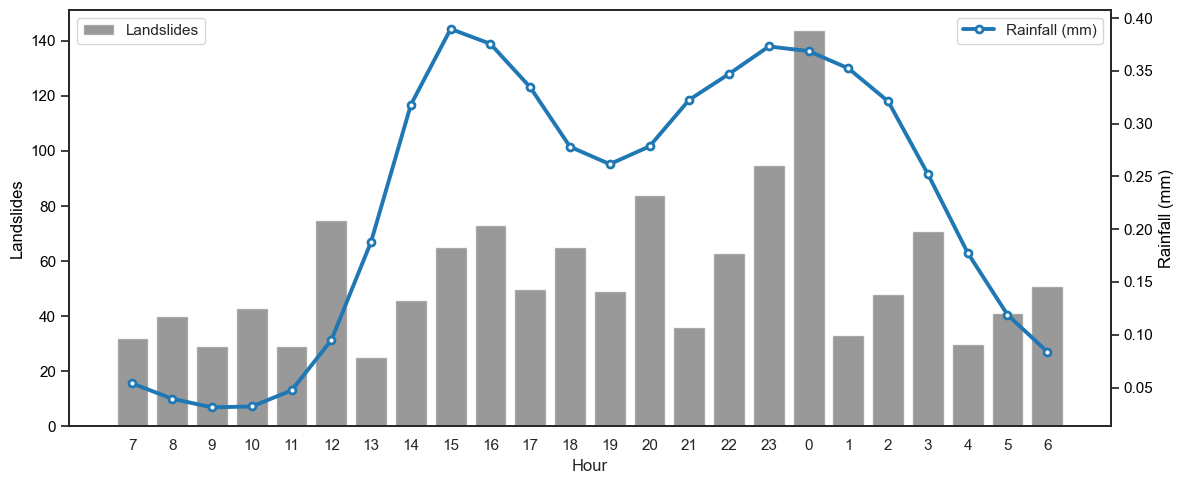

In [11]:
sns.set(style="white")
fig, ax1 = plt.subplots(figsize=(12, 5))
ax2 = ax1.twinx()
ax2.plot(x_pos, data_PM_reordenado.values, color="#1f77b4", marker='o', linestyle='-', linewidth=2.8, 
         markerfacecolor='white', markeredgewidth=2, markersize=5, label="Rainfall (mm)", zorder=2)

ax2.set_ylabel("Rainfall (mm)", color="black", fontsize=12)
ax2.tick_params(axis='y', labelcolor="black")

ax1.bar(x_pos, landslides_by_hour_reordenado.values, color="gray",  alpha=0.8, label="Landslides",zorder=2)
ax1.set_ylabel("Landslides", color="black", fontsize=12)
ax1.tick_params(axis='y', labelcolor="black")
ax1.set_xlabel("Hour", fontsize=12)

ax1.set_xticks(x_pos)
ax1.set_xticklabels(horas_reordenadas)

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

fig.tight_layout()
plt.show()
#plt.savefig(f'{output_figures}hourly_temporal.png', bbox_inches = "tight")

<h4 style="font-size: 20px;"><strong>Graphics hourly and monthly scale</strong></h4>

In [12]:
hourly_files = sorted(glob(hourly_input + 'H_Datos_Procesados_Est_*.csv'))

stations_with_paths = [(int(file.split('_')[-1].split('.')[0]), file) for file in hourly_files]

stations_with_paths_sorted = sorted(stations_with_paths, key=lambda x: x[0])
hourly_files = [station[1] for station in stations_with_paths_sorted]

all_stations_df = pd.DataFrame()

# Leer todos los archivos y almacenarlos en una lista
data_frames = []
for file in hourly_files[:-16]:  # Sin las estaciones de EPM
    station_data = pd.read_csv(file, index_col='Fecha', parse_dates=True)
    data_frames.append(station_data)

# Concatenar todos los DataFrames a la vez
all_stations_df = pd.concat(data_frames, axis=1)

all_stations_df = all_stations_df[(all_stations_df.index >= '2010-01-01') & (all_stations_df.index <= '2023-12-31')]
columns_to_drop = [col for col in all_stations_df.columns if 'Unnamed: 0' in col]
all_stations_df_cleaned = all_stations_df.drop(columns=columns_to_drop)

In [13]:
# Asegurarnos de que el índice de `all_stations_df_cleaned` es de tipo datetime
all_stations_df_cleaned = all_stations_df_cleaned.copy()
all_stations_df_cleaned.index = pd.to_datetime(all_stations_df_cleaned.index)

# Agregar columnas para el mes y la hora
all_stations_df_cleaned['Mes'] = all_stations_df_cleaned.index.month
all_stations_df_cleaned['Hora'] = all_stations_df_cleaned.index.hour

# Sumar todas las columnas de precipitación 'P' para obtener el total de precipitación en todas las estaciones por hora
all_stations_df_cleaned['Total_P'] = all_stations_df_cleaned.filter(like='P').mean(axis=1)

# Agrupar por Mes y Hora, y calcular el promedio de lluvia total (promedio entre todas las estaciones)
monthly_hourly_rainfall = all_stations_df_cleaned.groupby(['Mes', 'Hora'])['Total_P'].mean().unstack(level='Hora')

# Reindexar las columnas según las horas reordenadas
monthly_hourly_rainfall_reordenado = monthly_hourly_rainfall.reindex(columns=horas_reordenadas)


In [14]:
monthly_hourly_rainfall_reordenado

Hora,7,8,9,10,11,12,13,14,15,16,...,21,22,23,0,1,2,3,4,5,6
Mes,,,,,,,,,,,,,,,,,,,,,
1,0.028636,0.017698,0.010788,0.015847,0.022254,0.043524,0.025310,0.082773,0.227638,0.269981,...,0.134000,0.163759,0.130221,0.111596,0.095099,0.074990,0.070235,0.064894,0.045506,0.046965
2,0.025080,0.013925,0.016496,0.021022,0.024175,0.031015,0.059986,0.099760,0.296158,0.469219,...,0.115560,0.126666,0.141536,0.150603,0.149161,0.105910,0.091749,0.073013,0.065804,0.045963
3,0.057023,0.057125,0.040766,0.029112,0.043708,0.064221,0.119528,0.353894,0.548924,0.573266,...,0.269526,0.274097,0.298952,0.270721,0.274189,0.273412,0.198281,0.119960,0.099925,0.076560
4,0.068542,0.058371,0.048743,0.054936,0.065691,0.116084,0.286864,0.473991,0.530644,0.481141,...,0.442223,0.423775,0.445453,0.412272,0.380373,0.316590,0.229639,0.198405,0.151481,0.109310
5,0.047622,0.034264,0.038754,0.058885,0.104796,0.175025,0.330696,0.416403,0.429043,0.391805,...,0.529060,0.540894,0.547079,0.564690,0.532982,0.402098,0.304192,0.191783,0.131004,0.071737
6,0.049749,0.041568,0.026286,0.028324,0.046551,0.087625,0.133164,0.198025,0.220396,0.233551,...,0.326825,0.449836,0.539233,0.518905,0.469746,0.390033,0.250439,0.175160,0.108434,0.076860
7,0.050585,0.043847,0.021356,0.019734,0.029674,0.066273,0.096782,0.121892,0.146544,0.155064,...,0.234546,0.289474,0.373313,0.408830,0.452159,0.436715,0.247628,0.126432,0.074551,0.056248
8,0.070532,0.046474,0.028877,0.017055,0.024499,0.054609,0.116992,0.176167,0.146215,0.160116,...,0.192756,0.303809,0.375941,0.415487,0.454754,0.414346,0.335281,0.248144,0.176292,0.137823
9,0.064952,0.044634,0.024675,0.031161,0.045310,0.149650,0.277609,0.303680,0.292441,0.241787,...,0.354625,0.342277,0.376427,0.537769,0.520133,0.484583,0.403014,0.279715,0.178374,0.117744


In [15]:
# Definir los tamaños de los círculos según los intervalos
def get_circle_size(value):
    if value == 0:
        return 0  # Sin círculo
    elif 1 <= value <= 5:
        return 50  # Círculo pequeño
    elif 6 <= value <= 10:
        return 150  # Círculo mediano
    elif 11 <= value <= 20:
        return 250  # Círculo grande
    elif 21 <= value:
        return 400  # Círculo muy grande

# Crear una matriz con los tamaños escalados
scaled_sizes = np.array([[get_circle_size(val) for val in row] for row in landslides_by_hour_month.values])


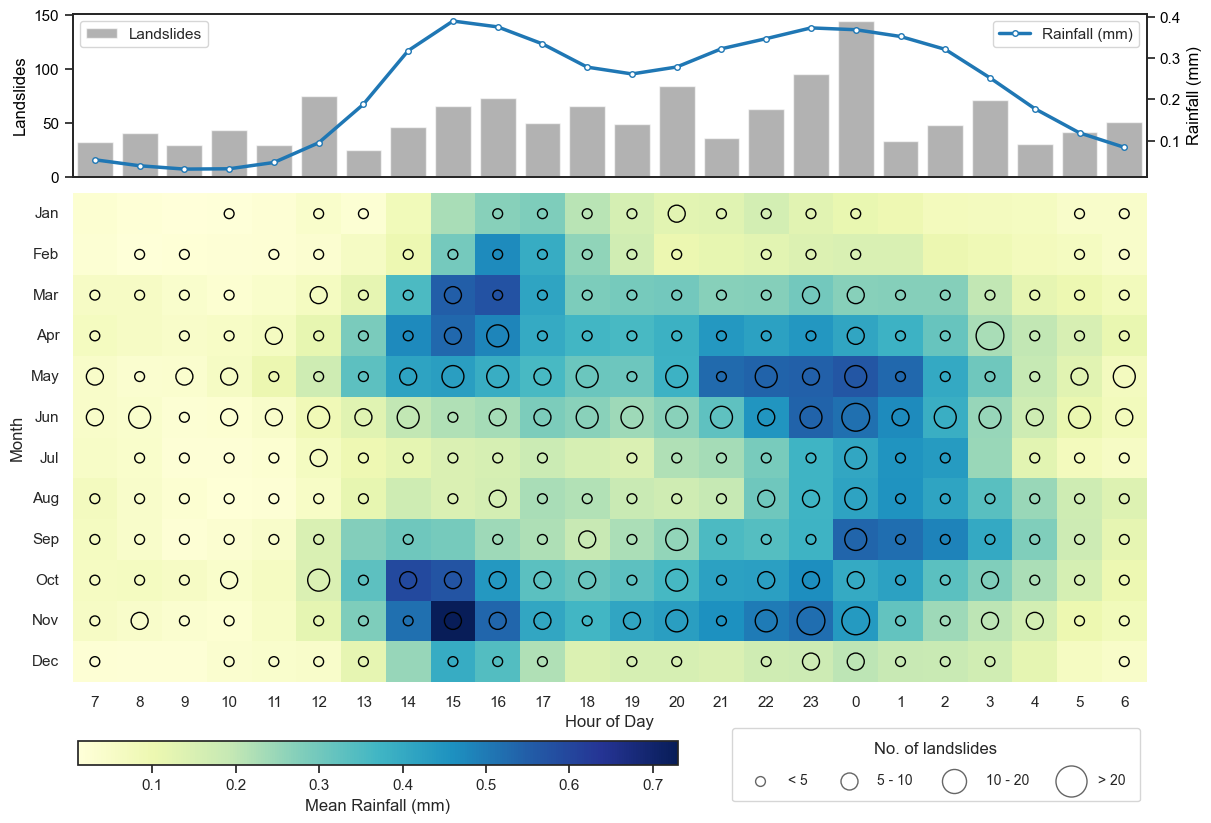

In [16]:
# Gráfico combinado
#figsize=(6.5, 4.5)
figsize=(12, 8)
# Crear la figura con dos subgráficos
fig, (ax_top, ax_heatmap) = plt.subplots(nrows=2, figsize=figsize, gridspec_kw={'height_ratios': [1, 3]}, constrained_layout=True)

# Ajustar el ancho de las barras para una mejor alineación
bar_width = 0.8 

# Parte superior: gráfica de barras y línea
ax2 = ax_top.twinx()
ax2.plot(x_pos, data_PM_reordenado.values, color="#1f77b4", marker='o', linestyle='-', linewidth=2.5, 
         markerfacecolor='white', markeredgewidth=1, markersize=4, label="Rainfall (mm)", zorder=2)

ax2.set_ylabel("Rainfall (mm)", color="black", fontsize=12)
ax2.tick_params(axis='y', labelcolor="black")

ax_top.bar(x_pos, landslides_by_hour_reordenado.values, color="gray", alpha=0.6, width=bar_width, label="Landslides", zorder=2)
ax_top.set_ylabel("Landslides", color="black", fontsize=12)
ax_top.tick_params(axis='y', labelcolor="black")

# Eliminar las etiquetas del eje X en la gráfica superior
ax_top.set_xticks([])
ax_top.set_xticklabels([])

ax_top.legend(loc="upper left")
ax2.legend(loc="upper right")

cmap = 'YlGnBu'
#cmap = 'coolwarm'
#cmap = 'BuPu'
#cmap = 'viridis'
#cmap = 'rainbow'
#cmap='cubehelix'
#cmap = 'Blues'
# Parte inferior: Mapa de calor
sns.heatmap(monthly_hourly_rainfall_reordenado, ax=ax_heatmap, cmap=cmap, 
            xticklabels=horas_reordenadas, yticklabels=[calendar.month_abbr[i] for i in range(1, 13)], annot=False, 
            cbar=False)

# Configurar el eje X e Y en el mapa de calor
ax_heatmap.set_xlabel('Hour of Day')
ax_heatmap.set_ylabel('Month')

ax_heatmap.set_yticklabels([calendar.month_abbr[i] for i in range(1, 13)], rotation=0)

for (i, j), val in np.ndenumerate(landslides_by_hour_month.values):
    if val > 0:  # Solo dibujar círculos donde hay deslizamientos
        ax_heatmap.scatter(j + 0.5, i + 0.5, s=scaled_sizes[i, j], facecolor='none', edgecolor='black', linewidth=1)

# Asegurarse de que los límites del eje X sean consistentes en ambos gráficos
ax_top.set_xlim(-0.5, len(horas_reordenadas) - 0.5)

cax = fig.add_axes([0.06, 0.05, 0.5, 0.03])  # [left, bottom, width, height]


cbar = fig.colorbar(ax_heatmap.collections[0], cax=cax, orientation='horizontal')
cbar.set_label('Mean Rainfall (mm)')

# Crear leyenda personalizada para los tamaños de los círculos
legend_labels = ['< 5', '5 - 10', ' 10 - 20', '> 20']
legend_sizes = [50, 150, 300, 500]

legend_circles = [plt.scatter([], [], s=size, color='white', alpha=0.6, edgecolor='black') for size in legend_sizes]
ax_heatmap.legend(legend_circles, legend_labels, loc='upper right', bbox_to_anchor=(1.0, -0.08), 
                  title="No. of landslides", borderpad=1, handletextpad=1, labelspacing=1.2, ncol=4, fontsize=10)

plt.show()
# Guardar la figura
#plt.savefig(f'{output_figures}combined_temporal_scale.png', bbox_inches="tight")
#plt.savefig('figura.png', dpi=300, bbox_inches='tight')

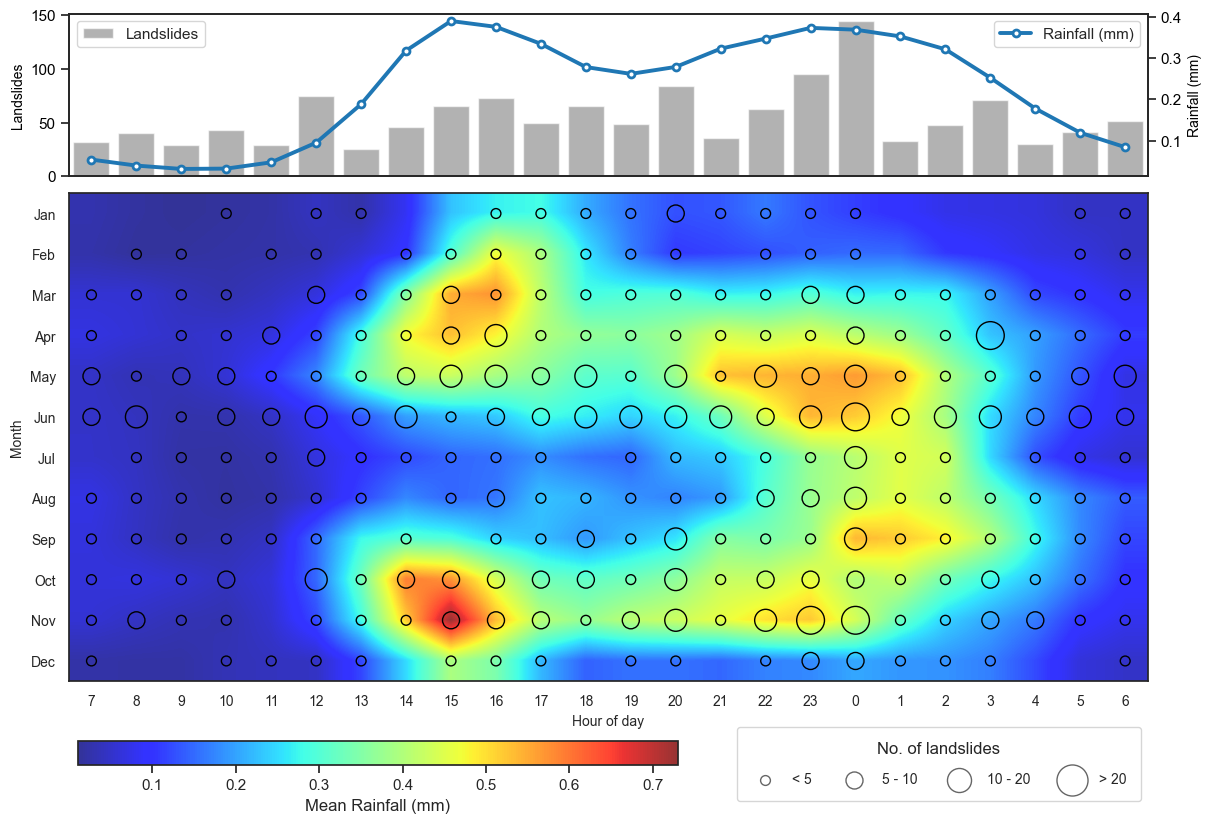

In [17]:
figsize = (12, 8)
fig, (ax_top, ax) = plt.subplots(nrows=2, figsize=figsize, gridspec_kw={'height_ratios': [1, 3]}, constrained_layout=True)

bar_width = 0.8

# Parte superior: gráfica de barras y línea
ax2 = ax_top.twinx()
ax2.plot(x_pos, data_PM_reordenado.values, color="#1f77b4", marker='o', linestyle='-', linewidth=2.8, 
         markerfacecolor='white', markeredgewidth=2, markersize=5, label="Rainfall (mm)", zorder=2)

ax2.set_ylabel("Rainfall (mm)", color="black", fontsize=10)
ax2.tick_params(axis='y', labelcolor="black")

ax_top.bar(x_pos, landslides_by_hour_reordenado.values, color="gray", alpha=0.6, width=bar_width, label="Landslides", zorder=2)
ax_top.set_ylabel("Landslides", color="black", fontsize=10)
ax_top.tick_params(axis='y', labelcolor="black")

# Eliminar las etiquetas del eje X en la gráfica superior
ax_top.set_xticks([])
ax_top.set_xticklabels([])

ax_top.legend(loc="upper left")
ax2.legend(loc="upper right")

# Parte inferior: Mapa de calor
im = ax.imshow(monthly_hourly_rainfall_reordenado.values, cmap='jet', interpolation='bilinear', aspect='auto', alpha=0.8)

# Configurar el eje X e Y en el mapa de calor
ax.set_xlabel('Hour of day', fontsize=10)
ax.set_ylabel('Month', fontsize=10)

# Configurar las etiquetas del eje Y
ax.set_yticks(np.arange(12))
ax.set_yticklabels([calendar.month_abbr[i] for i in range(1, 13)], rotation=0, fontsize=10)
ax.set_xticks(np.arange(len(horas_reordenadas)))
ax.set_xticklabels(horas_reordenadas, fontsize=10)

# Ajuste para alinear los círculos
for (i, j), val in np.ndenumerate(landslides_by_hour_month.values):
    if val > 0:
        ax.scatter(j, i, s=scaled_sizes[i, j], facecolor='none', edgecolor='black', linewidth=1)

# Asegurarse de que los límites del eje X sean consistentes en ambos gráficos
ax_top.set_xlim(-0.5, len(horas_reordenadas) - 0.5)

cax = fig.add_axes([0.06, 0.05, 0.5, 0.03])  # [left, bottom, width, height]

cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label('Mean Rainfall (mm)', fontsize=12)

# Crear leyenda personalizada para los tamaños de los círculos
legend_labels = ['< 5', '5 - 10', '10 - 20', '> 20']
legend_sizes = [50, 150, 300, 500]

legend_circles = [plt.scatter([], [], s=size, color='white', alpha=0.6, edgecolor='black') for size in legend_sizes]
ax.legend(legend_circles, legend_labels, loc='upper right', bbox_to_anchor=(1.0, -0.08), 
                  title="No. of landslides", borderpad=1, handletextpad=1, labelspacing=1.2, ncol=4, fontsize=10)

plt.show()
#plt.savefig(f'{output_figures}hourly_monthly_scale.png', bbox_inches="tight")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import glob

# Definir los tamaños de los círculos según los intervalos
def get_circle_size(value):
    if value == 0:
        return 0  # Sin círculo
    elif 1 <= value <= 5:
        return 50  # Círculo pequeño
    elif 6 <= value <= 10:
        return 150  # Círculo mediano
    elif 11 <= value <= 20:
        return 250  # Círculo grande
    elif 21 <= value:
        return 400  # Círculo muy grande

# Leer y concatenar archivos CSV
def read_and_concat_files(file_paths, exclude_epm=False):
    if exclude_epm:
        file_paths = file_paths[:-16]  # Sin las estaciones de EPM
    
    data_frames = []
    for file in file_paths:
        station_data = pd.read_csv(file, index_col='Fecha', parse_dates=True, usecols=lambda col: 'Unnamed: 0' not in col)
        data_frames.append(station_data)
    
    return pd.concat(data_frames, axis=1)

# Leer y ordenar archivos
hourly_input = "path_to_hourly_files/"  # Ajusta esta ruta
hourly_files = sorted(glob.glob(hourly_input + 'H_Datos_Procesados_Est_*.csv'))
stations_with_paths = [(int(file.split('_')[-1].split('.')[0]), file) for file in hourly_files]
stations_with_paths_sorted = sorted(stations_with_paths, key=lambda x: x[0])
hourly_files = [station[1] for station in stations_with_paths_sorted]

# Leer y procesar los datos de todas las estaciones
all_stations_df = read_and_concat_files(hourly_files, exclude_epm=True)
all_stations_df = all_stations_df[(all_stations_df.index >= '2010-01-01') & (all_stations_df.index <= '2023-12-31')]

# Asegurarse de que el índice es de tipo datetime
all_stations_df.index = pd.to_datetime(all_stations_df.index)

# Agregar columnas para el mes y la hora
all_stations_df['Mes'] = all_stations_df.index.month
all_stations_df['Hora'] = all_stations_df.index.hour

# Calcular el total de precipitación promedio por hora
all_stations_df['Total_P'] = all_stations_df.filter(like='P').mean(axis=1)

# Agrupar por mes y hora
monthly_hourly_rainfall = all_stations_df.groupby(['Mes', 'Hora'])['Total_P'].mean().unstack(level='Hora')

# Reordenar las horas
horas_reordenadas = list(range(24))  # Asumiendo que las horas están de 0 a 23
monthly_hourly_rainfall_reordenado = monthly_hourly_rainfall.reindex(columns=horas_reordenadas)

# Procesar datos de deslizamientos
path_inventory = "path_to_inventory/"  # Ajusta esta ruta
landslides_df = pd.read_csv(f'{path_inventory}inventory_DAGRD.csv')
landslides_df['fecha_hora_evento'] = pd.to_datetime(landslides_df['fecha_hora_evento'], errors='coerce')
landslides_df['Hora'] = landslides_df['fecha_hora_evento'].dt.hour
landslides_by_hour = landslides_df.groupby('Hora').size()

# Reindexar los datos de deslizamientos según las horas reordenadas
landslides_by_hour_reordenado = landslides_by_hour.reindex(horas_reordenadas, fill_value=0)

# Crear una matriz con los tamaños escalados para el mapa de calor
landslides_by_hour_month = landslides_df.groupby([landslides_df['fecha_hora_evento'].dt.month, 'Hora']).size().unstack(fill_value=0)
scaled_sizes = np.array([[get_circle_size(val) for val in row] for row in landslides_by_hour_month.values])

# Graficar los datos
figsize = (12, 8)
fig, (ax_top, ax) = plt.subplots(nrows=2, figsize=figsize, gridspec_kw={'height_ratios': [1, 3]}, constrained_layout=True)

bar_width = 0.8
x_pos = range(len(horas_reordenadas))

# Parte superior: gráfica de barras y línea
# Datos ficticios para data_PM_reordenado, reemplazar con los datos reales
data_PM_reordenado = pd.Series([10] * 24, index=horas_reordenadas)  # Reemplazar con los valores reales

ax2 = ax_top.twinx()
ax2.plot(x_pos, data_PM_reordenado.values, color="#1f77b4", marker='o', linestyle='-', linewidth=2.8, 
         markerfacecolor='white', markeredgewidth=2, markersize=5, label="Rainfall (mm)", zorder=2)

ax2.set_ylabel("Rainfall (mm)", color="black", fontsize=10)
ax2.tick_params(axis='y', labelcolor="black")

ax_top.bar(x_pos, landslides_by_hour_reordenado.values, color="gray", alpha=0.6, width=bar_width, label="Landslides", zorder=2)
ax_top.set_ylabel("Landslides", color="black", fontsize=10)
ax_top.tick_params(axis='y', labelcolor="black")

# Eliminar las etiquetas del eje X en la gráfica superior
ax_top.set_xticks([])
ax_top.set_xticklabels([])

# Agregar leyendas a los gráficos de la parte superior
lines, labels = ax_top.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax_top.legend(lines + lines2, labels + labels2, loc='upper left')

# Parte inferior: Mapa de calor
im = ax.imshow(monthly_hourly_rainfall_reordenado.values, cmap='jet', interpolation='bilinear', aspect='auto', alpha=0.8)

# Configurar el eje X e Y en el mapa de calor
ax.set_xlabel('Hour of day', fontsize=10)
ax.set_ylabel('Month', fontsize=10)

# Configurar las etiquetas del eje Y
ax.set_yticks(np.arange(12))
ax.set_yticklabels([calendar.month_abbr[i] for i in range(1, 13)], rotation=0, fontsize=10)
ax.set_xticks(np.arange(len(horas_reordenadas)))
ax.set_xticklabels(horas_reordenadas, fontsize=10)

# Ajuste para alinear los círculos
total_months, total_hours = landslides_by_hour_month.shape
for i in range(total_months):
    for j in range(total_hours):
        val = landslides_by_hour_month.iloc[i, j]
        if val > 0:
            ax.scatter(j, i, s=scaled_sizes[i, j], facecolor='none', edgecolor='black', linewidth=1)

# Asegurarse de que los límites del eje X sean consistentes en ambos gráficos
ax_top.set_xlim(-0.5, len(horas_reordenadas) - 0.5)

# Barra de color
cax = fig.add_axes([0.06, 0.05, 0.5, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label('Mean Rainfall (mm)', fontsize=12)

# Crear leyenda personalizada para los tamaños de los círculos
legend_labels = ['< 5', '5 - 10', '10 - 20', '> 20']
legend_sizes = [50, 150, 250, 400]

legend_circles = [plt.scatter([], [], s=size, facecolor='none', edgecolor='black', linewidth=1) for size in legend_sizes]
ax.legend(legend_circles, legend_labels, loc='upper right', bbox_to_anchor=(1.0, -0.08), 
          title="No. of landslides", borderpad=1, handletextpad=1, labelspacing=1.2, ncol=4, fontsize=10)

plt.show()
# plt.savefig(f'{output_figures}hourly_monthly_scale.png', bbox_inches="tight")